## 多因子模型

In [41]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from utils import *
import os
import joblib

In [42]:
def mse1(y_true, y_pred):
    if(y_true is None or y_pred is None):
        return 0
    
    return np.mean((y_true - y_pred)**2)

In [43]:
start_date = '2011-04-30'
end_date = '2016-04-30'

In [44]:
df_all = pd.read_csv('data/df_all.csv', dtype={'asset': str})
df_all['date'] = pd.to_datetime(df_all['date'])

# df_all = df_all[(df_all['date'] >= start_date) & (df_all['date'] <= end_date)]

df_all.drop(['Unnamed: 0', 'Rmrf', 'Smb', 'Hml'], axis=1, inplace=True)
df_all_pivot = df_all.pivot(index='date', columns='asset')

In [45]:
df_all_pivot.columns

MultiIndex([('open', '000001'),
            ('open', '000002'),
            ('open', '000009'),
            ('open', '000012'),
            ('open', '000021'),
            ('open', '000027'),
            ('open', '000031'),
            ('open', '000039'),
            ('open', '000046'),
            ('open', '000059'),
            ...
            (  'ep', '601898'),
            (  'ep', '601899'),
            (  'ep', '601918'),
            (  'ep', '601919'),
            (  'ep', '601939'),
            (  'ep', '601958'),
            (  'ep', '601988'),
            (  'ep', '601989'),
            (  'ep', '601991'),
            (  'ep', '601998')],
           names=[None, 'asset'], length=7776)

In [46]:
print("已经有的因子：")
df_all.columns

已经有的因子：


Index(['asset', 'date', 'open', 'close', 'high', 'low', 'volume', 'amount',
       'vwap', 'pctChg', 'turnover', 'benchmark_open', 'benchmark_close',
       'benchmark_high', 'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd',
       'epq', 'emq', 'sgq', 'alaq', 'pmq', 'cta', 'size', 'rf', 'bm', 'ep'],
      dtype='object')

In [47]:
returns = pd.read_csv('data/returns.csv', index_col=0)
returns.index = pd.to_datetime(returns.index)
all_time_index = returns.index
all_time_index

# returns = returns[(returns.index >= start_date) & (returns.index <= end_date)]

# return_copy = returns.copy()
# return_copy = return_copy[(return_copy.index >= start_date) & (return_copy.index <= end_date)]

# dates = return_copy.index
# dates

DatetimeIndex(['2011-05-03', '2011-05-04', '2011-05-05', '2011-05-06',
               '2011-05-09', '2011-05-10', '2011-05-11', '2011-05-12',
               '2011-05-13', '2011-05-16',
               ...
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-24', '2023-04-25', '2023-04-26',
               '2023-04-27', '2023-04-28'],
              dtype='datetime64[ns]', name='date', length=2918, freq=None)

In [48]:
returns.columns
assets = returns.columns

In [49]:
# 从因子数据中读取因子
alphaset = 'ourAlphas'
subset = '20110430'

from MyBacktrader import get_alpha_list

alpha_names = get_alpha_list(f'alphas/{alphaset}/{subset}')
# alpha_names = ['alpha_financial_health']

for alpha_name in alpha_names:
    alpha = pd.read_csv('alphas/{}/{}/{}.csv'.format(alphaset, subset, alpha_name))
    
    # 从因子数据中读取因子
    alpha = alpha.set_index('date')
    alpha.index = pd.to_datetime(alpha.index)
    
    # alpha = alpha[(alpha.index >= start_date) & (alpha.index <= end_date)]

    # 给 alpha 添加双重索引
    alpha.columns = pd.MultiIndex.from_product([[f'{alpha_name}'], alpha.columns], names=['', 'asset'])

    # 合并 alpha 到 df_all_pivot
    df_all_pivot = pd.concat([df_all_pivot, alpha], axis=1)

    # print(df_combined)
    # 合并到df_all_pivot
    # df_all_pivot = pd.concat([df_all_pivot, alpha], axis=1)

In [50]:
print("已经有的因子：")
print(df_all_pivot.columns.get_level_values(0).unique())

已经有的因子：
Index(['open', 'close', 'high', 'low', 'volume', 'amount', 'vwap', 'pctChg',
       'turnover', 'benchmark_open', 'benchmark_close', 'benchmark_high',
       'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd', 'epq', 'emq',
       'sgq', 'alaq', 'pmq', 'cta', 'size', 'rf', 'bm', 'ep', 'alpha001',
       'alpha_ALAQ', 'alpha_bm', 'alpha_CH3', 'alpha_CH3_Size',
       'alpha_CH3_Size_NOT', 'alpha_CH3_turnover', 'alpha_CH3_turnover_NOT',
       'alpha_CH3_Value', 'alpha_CH3_Value_NOT', 'alpha_CTA', 'alpha_CVD',
       'alpha_EMQ', 'alpha_EP', 'alpha_EPQ', 'alpha_Fama_French',
       'alpha_financial_health', 'alpha_High_Low', 'alpha_Hml',
       'alpha_Hml_NOT', 'alpha_liquidity', 'alpha_market_alpha',
       'alpha_momentum', 'alpha_momentum_60', 'alpha_multi', 'alpha_PMQ',
       'alpha_PMQ_momentum', 'alpha_Price_VWAP', 'alpha_reversal',
       'alpha_Rmrf', 'alpha_ROA_momentum', 'alpha_ROE', 'alpha_ROE_ROA',
       'alpha_rsi', 'alpha_sentiment', 'alpha_SGQ', 'alpha_SGQ_vol

## 三因子：FamaFrench

滚动回归：

In [ ]:
import os
import joblib
from statsmodels.api import OLS, add_constant
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from tqdm import tqdm

Y = returns - df_all_pivot['rf'].values
# print(Y.head())

# 截取时间段
Y = Y[(Y.index >= start_date) & (Y.index <= end_date)]

# X_fama = df_all_pivot[['alpha_size', 'alpha_bm', 'alpha_Rmrf']]
# X_fama = df_all_pivot[['Rmrf', 'Smb', 'Hml']]
X_fama = df_all_pivot[['alpha_Rmrf', 'alpha_Smb', 'alpha_Hml']]

X_fama = X_fama[(X_fama.index >= start_date) & (X_fama.index <= end_date)]

X_fama.columns.get_level_values(0).unique()

# 提取资产列表（多重索引的第二层）
assets = X_fama.columns.get_level_values(1).unique()
assets = ['601939']
dates = Y.index

# 创建 DataFrame 存储回归结果
expected_columns = ['Asset'] + list(X_fama.columns.get_level_values(0).unique()) + ['Intercept']

# 滚动窗口设置
window_size = 60  # 滑动窗口大小
test_size = 20    # 测试集大小
expected_columns = ['Asset'] + list(X_fama.columns.get_level_values(0).unique()) + ['Intercept']

famafrench_models = {}
total_mse_famafrench = 0

# 创建存储预测结果的 DataFrame
regression_preds = pd.DataFrame(index=dates, columns=assets)

# 对每个资产进行滚动回归
for asset in tqdm(assets):
    # 提取该资产对应的 Y 和 X
    y = Y[asset].dropna()
    x = X_fama.xs(asset, axis=1, level=1).reindex(y.index)  # 确保时间对齐

    # 初始化模型存储路径
    asset_model_dir = f'models/famafrench_models_rolling/{asset}'
    if not os.path.exists(asset_model_dir):
        os.makedirs(asset_model_dir)

    # 滚动窗口
    for start in range(len(x) - window_size - test_size + 1):
        # 确定滚动窗口的训练集和测试集
        train_end = start + window_size
        test_end = train_end + test_size

        X_train = x.iloc[start:train_end]
        y_train = y.iloc[start:train_end]
        X_test = x.iloc[train_end:test_end]
        y_test = y.iloc[train_end:test_end]

        # 添加常数项
        X_train = add_constant(X_train)
        X_test = add_constant(X_test)

        # 补充缺失列
        missing_columns_train = [col for col in expected_columns if col not in X_train.columns and col != 'Asset']
        for col in missing_columns_train:
            X_train[col] = 0
        X_train = X_train[expected_columns[1:]]  # 排序

        missing_columns_test = [col for col in expected_columns if col not in X_test.columns and col != 'Asset']
        for col in missing_columns_test:
            X_test[col] = 0
        X_test = X_test[expected_columns[1:]]  # 排序

        # 回归分析
        model = OLS(y_train, X_train).fit()

        # 保存模型
        model_filename = f'{asset_model_dir}/model_window_{start}.pkl'
        joblib.dump(model, model_filename)

        # 预测
        predictions = model.predict(X_test)
        regression_preds.loc[X_test.index, asset] = predictions

        # 计算误差
        mse_val = mean_squared_error(y_test, predictions)
        total_mse_famafrench += mse_val

# 输出平均 MSE
average_mse_famafrench = total_mse_famafrench / (len(assets) * (len(x) - window_size - test_size + 1))
print(f"Average MSE across all assets: {average_mse_famafrench}")

100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Average MSE across all assets: 8.184740307170498


生成三因子：

In [27]:
Y = returns - df_all_pivot['rf'].values
# print(Y.head())

# 截取时间段
Y = Y[(Y.index >= start_date) & (Y.index <= end_date)]

# X_fama = df_all_pivot[['alpha_size', 'alpha_bm', 'alpha_Rmrf']]
# X_fama = df_all_pivot[['Rmrf', 'Smb', 'Hml']]

# X_fama = df_all_pivot[['alpha_Rmrf', 'alpha_Smb', 'alpha_Hml']] # 使用市值加权平均
X_fama = df_all_pivot[['alpha_Rmrf', 'alpha_Smb_NOT', 'alpha_Hml_NOT']] # 使用等权平均 

X_fama = X_fama[(X_fama.index >= start_date) & (X_fama.index <= end_date)]

X_fama.columns.get_level_values(0).unique()

# 提取资产列表（多重索引的第二层）
assets = X_fama.columns.get_level_values(1).unique()
# assets = ['601939']
dates = Y.index

# 创建 DataFrame 存储回归结果
expected_columns = ['Asset'] + list(X_fama.columns.get_level_values(0).unique()) + ['Intercept']

famafrench_models = {}

total_mse_famafrench = 0

# 对每个资产进行回归
for asset in tqdm(assets):
    # print("asset: ", asset)
    # 提取该资产对应的 Y 和 X
    y = Y[asset].dropna()
    x = X_fama.xs(asset, axis=1, level=1).reindex(y.index)  # 确保时间对齐

    # 添加常数项
    x = sm.add_constant(x)

    # 找出缺失的列
    missing_columns = [col for col in expected_columns if col not in x.columns and col != 'Asset']
    
    # 手动补充缺失列
    for col in missing_columns:
        x[col] = 0

    # 确保列顺序一致
    x = x[expected_columns[1:]]  # 排除 'Asset'，其余列按 expected_columns 的顺序排列
    
    # 回归分析
    model = sm.OLS(y, x).fit()
    
    pred = model.predict(x)
    
    # 计算 MSE
    mse_val = mse1(y, pred)
    
    total_mse_famafrench += mse_val
    
    # 保存回归模型
    famafrench_models[asset] = model
    
    # 如果路径不存在，创建路径
    if not os.path.exists('models/famafrench_models'):
        os.makedirs('models/famafrench_models')
    
    joblib.dump(model, f'models/famafrench_models/{asset}.pkl')

    # # 回归分析
    # model = sm.OLS(y, x).fit()
    
    # pred = model.predict(x)
    # regression_preds[asset] = pred

    # # 计算 MSE
    # mse_val = mse1(y, pred)
    # total_mse_regression += mse_val

    # # 记录回归结果
    # result = [asset] + list(model.params.reindex(expected_columns[1:]).fillna(0).values)
    
    # # 保存回归模型
    # regression_models[asset] = model

    # 检查 result 的长度和 regression_betas 的列数
    # print("result 的长度:", len(result))
    # print("regression_betas 的列数:", len(regression_betas.columns))

    # regression_betas.loc[len(regression_betas)] = result
    

# 设置列名
# regression_betas.columns = ['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept']

print("MSE:")
print(total_mse_famafrench)

100%|██████████| 288/288 [00:01<00:00, 183.03it/s]

MSE:
0.12238424403396803


In [58]:
asset_id = '601939'

assets_id = iter(assets)

In [59]:
asset_id = next(assets_id)
# asset_id = '601939'

results = famafrench_models[asset_id]

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 000001   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          9.890e+06
Date:                 周一, 09 12月 2024   Prob (F-statistic):                        0.00
Time:                        00:57:53   Log-Likelihood:                          3043.5
No. Observations:                1185   AIC:                                     -6081.
Df Residuals:                    1182   BIC:                                     -6066.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

e:\Anaconda\envs\py310\lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [28]:
def compute_monthly_returns(daily_returns):
    # 填充缺失值（前向填充）
    daily_returns_filled = daily_returns.fillna(method='ffill')  # 或者使用 bfill
    mean_returns = daily_returns_filled.mean(axis=1)
    daily_returns_filled.fillna(mean_returns, inplace=True)  # 填充剩余缺失值
    
    # 如果还有缺失值，返回 None
    if daily_returns_filled.isnull().sum().sum() > 0:
        return None

    # 对每个月的数据进行处理
    monthly_returns = (1 + daily_returns_filled).resample('M').prod() - 1
    return monthly_returns

# 转换 Y 和 X_fama 为长表格式（面板数据）
Y_flat = Y.stack().reset_index()
Y_flat.columns = ['Date', 'Asset', 'Return']

X_fama_flat = X_fama.stack(level='asset').reset_index()
# X_fama_flat.columns = ['Date', 'Asset', 'alpha_Rmrf', 'alpha_Smb', 'alpha_Hml']
X_fama_flat.columns = ['Date', 'Asset', 'alpha_Rmrf', 'alpha_Smb_NOT', 'alpha_Hml_NOT']

# 合并 Y 和 X_fama
panel_data = pd.merge(Y_flat, X_fama_flat, on=['Date', 'Asset'])

# 设置面板数据的多重索引
panel_data = panel_data.set_index(['Asset', 'Date'])

# 因变量和自变量
y = panel_data['Return']
# X = panel_data[['alpha_Rmrf', 'alpha_Smb', 'alpha_Hml']]
X = panel_data[['alpha_Rmrf', 'alpha_Smb_NOT', 'alpha_Hml_NOT']]

# 添加常数项
X = sm.add_constant(X)

# 面板回归（固定效应模型，考虑资产特定影响）
model = sm.OLS(y, X).fit()

# 输出回归结果
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.539e+08
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:38:04   Log-Likelihood:             8.1782e+05
No. Observations:              337919   AIC:                        -1.636e+06
Df Residuals:                  337915   BIC:                        -1.636e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001      0.000      0.984

In [ ]:
# 确保索引为 Datetime 格式
Y.index = pd.to_datetime(Y.index)
X_fama.index = pd.to_datetime(X_fama.index)

# 转换为月度数据
# Y_monthly = compute_monthly_returns(Y)  # 收益率取月度复合收益率

# Y_monthly.fillna(Y_monthly.mean(), inplace=True)  # 填充剩余缺失值

Y_monthly = Y.resample('M').mean()  # 收益率取月度均值

X_fama_monthly = X_fama.resample('M').mean()  # 因子值取月度均值


# 转换为长表格式（面板数据）
Y_flat = Y_monthly.stack().reset_index()
Y_flat.columns = ['Date', 'Asset', 'Return']

X_fama_flat = X_fama_monthly.stack(level='asset').reset_index()
# X_fama_flat.columns = ['Date', 'Asset', 'alpha_Rmrf', 'alpha_Smb', 'alpha_Hml']
X_fama_flat.columns = ['Date', 'Asset', 'alpha_Rmrf', 'alpha_Smb_NOT', 'alpha_Hml_NOT']

# 合并数据
panel_data = pd.merge(Y_flat, X_fama_flat, on=['Date', 'Asset'])
# 设置多重索引
panel_data = panel_data.set_index(['Asset', 'Date'])

# 因变量和自变量
y = panel_data['Return']
# X = panel_data[['alpha_Rmrf', 'alpha_Smb', 'alpha_Hml']]
X = panel_data[['alpha_Rmrf', 'alpha_Smb_NOT', 'alpha_Hml_NOT']]

# 添加常数项
X = sm.add_constant(X)

# 面板回归
model = sm.OLS(y, X).fit()

# 输出回归结果
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.401e+08
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:49:44   Log-Likelihood:                 64231.
No. Observations:               17034   AIC:                        -1.285e+05
Df Residuals:                   17030   BIC:                        -1.284e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.000      1.103

In [ ]:
# 初始化存储因子的字典
selected_factors = {}

# 遍历每个时间点
for time_point in tqdm(X.index):
    # 提取当前时间点的 X 和 Y
    X_time = X.loc[time_point].unstack(level=0)  # 转换为因子为列，股票为行的 DataFrame
    Y_time = Y.loc[time_point]

    # 清理缺失值
    X_time = X_time.dropna()
    Y_time = Y_time.loc[X_time.index].dropna()
    X_time = X_time.loc[Y_time.index]

    # 执行逐步回归
    if not X_time.empty and not Y_time.empty:  # 确保数据非空
        # model, selected_vars = stepwise_regression(Y_time, X_time)
        # selected_factors[time_point] = selected_vars
        
        # print(f'{time_point} 选择的因子：{selected_vars}')
        
        model = sm.OLS(Y_time, sm.add_constant(X_time)).fit()
        
        # 如果路径不存在，创建路径
        if not os.path.exists('models/cut'):
            os.makedirs('models/cut')
        
        # 保存模型
        time = time_point.strftime('%Y-%m-%d')
        joblib.dump(model, f'models/cut/{time}.pkl')
    else:
        selected_factors[time_point] = []

# 将选择的因子保存为 DataFrame
selected_factors_df = pd.DataFrame.from_dict(selected_factors, orient='index')
selected_factors_df.index = pd.to_datetime(selected_factors_df.index)  # 确保时间格式正确
# selected_factors_df.to_csv('selected_factors.csv')

100%|██████████| 1460/1460 [00:21<00:00, 69.40it/s]


## 三因子：CH3

In [62]:
Y = returns - df_all_pivot['rf'].values
# print(Y.head())

# 截取时间段
Y = Y[(Y.index >= start_date) & (Y.index <= end_date)]

X_ch3 = df_all_pivot[['alpha_size', 'alpha_EP', 'alpha_turnover', 'alpha_Rmrf']]

X_ch3 = X_ch3[(X_ch3.index >= start_date) & (X_ch3.index <= end_date)]

X_ch3.columns.get_level_values(0).unique()

# 提取资产列表（多重索引的第二层）
assets = X_ch3.columns.get_level_values(1).unique()
# assets = ['601939']
dates = Y.index

# 创建 DataFrame 存储回归结果
expected_columns = ['Asset'] + list(X_ch3.columns.get_level_values(0).unique()) + ['Intercept']

ch3_models = {}

total_mse_ch3 = 0

# 对每个资产进行回归
for asset in tqdm(assets):
    # print("asset: ", asset)
    # 提取该资产对应的 Y 和 X
    y = Y[asset].dropna()
    x = X_ch3.xs(asset, axis=1, level=1).reindex(y.index)  # 确保时间对齐

    # 添加常数项
    x = sm.add_constant(x)

    # 找出缺失的列
    missing_columns = [col for col in expected_columns if col not in x.columns and col != 'Asset']
    
    # 手动补充缺失列
    for col in missing_columns:
        x[col] = 0

    # 确保列顺序一致
    x = x[expected_columns[1:]]  # 排除 'Asset'，其余列按 expected_columns 的顺序排列
    
    # 回归分析
    model = sm.OLS(y, x).fit()
    
    pred = model.predict(x)
    
    # 计算 MSE
    mse_val = mse1(y, pred)
    
    total_mse_ch3 += mse_val
    
    # 保存回归模型
    ch3_models[asset] = model
    
    # 如果路径不存在，创建路径
    if not os.path.exists('models/ch3_models'):
        os.makedirs('models/ch3_models')
    
    joblib.dump(model, f'models/ch3_models/{asset}.pkl')

    # # 回归分析
    # model = sm.OLS(y, x).fit()
    
    # pred = model.predict(x)
    # regression_preds[asset] = pred

    # # 计算 MSE
    # mse_val = mse1(y, pred)
    # total_mse_regression += mse_val

    # # 记录回归结果
    # result = [asset] + list(model.params.reindex(expected_columns[1:]).fillna(0).values)
    
    # # 保存回归模型
    # regression_models[asset] = model

    # 检查 result 的长度和 regression_betas 的列数
    # print("result 的长度:", len(result))
    # print("regression_betas 的列数:", len(regression_betas.columns))

    # regression_betas.loc[len(regression_betas)] = result
    

# 设置列名
# regression_betas.columns = ['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept']

print("MSE:")
print(total_mse_ch3)

  0%|          | 0/288 [00:00<?, ?it/s]

100%|██████████| 288/288 [00:01<00:00, 181.94it/s]

MSE:
0.13723653738798983


In [63]:
asset_id = '601939'

results = famafrench_models[asset_id]

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 601939   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.618e+07
Date:                 周一, 09 12月 2024   Prob (F-statistic):                        0.00
Time:                        01:01:45   Log-Likelihood:                          3865.4
No. Observations:                1207   AIC:                                     -7725.
Df Residuals:                    1204   BIC:                                     -7709.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

e:\Anaconda\envs\py310\lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


## 这里

In [63]:
Y = returns - df_all_pivot['rf'].values
# print(Y.head())

start_date = '2013-04-30'
end_date = '2016-04-30'

# 截取时间段
Y = Y[(Y.index >= start_date) & (Y.index <= end_date)]


columns_to_change = ['alpha_CH3_Size_NOT', 'alpha_CH3_Value_NOT', 'alpha_Rmrf', 'alpha_CH3_turnover_NOT']

X_ch3 = df_all_pivot[columns_to_change]

# X_ch3 = df_all_pivot[['alpha_CH3_Size', 'alpha_CH3_Value', 'alpha_Rmrf']]

# X_ch3 = df_all_pivot[['alpha_CH3_Size', 'alpha_CH3_Value', 'alpha_Rmrf','alpha_CH3_turnover']]

# X_ch3 = df_all_pivot[['alpha_CH3_Size_NOT', 'alpha_CH3_Value_NOT', 'alpha_Rmrf']]

# X_ch3 = df_all_pivot[['alpha_CH3_Size_NOT', 'alpha_CH3_Value_NOT', 'alpha_Rmrf', 'alpha_CH3_turnover_NOT']]

# X_ch3 = df_all_pivot[['alpha_size', 'alpha_EP', 'alpha_Rmrf']]


X_ch3 = X_ch3[(X_ch3.index >= start_date) & (X_ch3.index <= end_date)]

X_ch3.columns.get_level_values(0).unique()

# 确保索引是 Datetime 格式
Y.index = pd.to_datetime(Y.index)
X_ch3.index = pd.to_datetime(X_ch3.index)

# 转换为月度数据，按月取均值
Y_monthly = Y.resample('M').mean()  # 收益率 
X_ch3_monthly = X_ch3.resample('M').mean()  # 因子按月取均值

# # 不转换为月度数据，直接使用日度数据
# Y_monthly = Y
# X_ch3_monthly = X_ch3

# 转换为长表格式（面板数据）
Y_flat = Y_monthly.stack().reset_index()
Y_flat.columns = ['Date', 'Asset', 'Return']

X_ch3_flat = X_ch3_monthly.stack(level='asset').reset_index()
# X_ch3_flat.columns = ['Date', 'Asset', 'alpha_CH3_Size', 'alpha_CH3_Value', 'alpha_Rmrf']
# X_ch3_flat.columns = ['Date', 'Asset', 'alpha_CH3_Size_NOT', 'alpha_CH3_Value_NOT', 'alpha_Rmrf']
# X_ch3_flat.columns = ['Date', 'Asset', 'alpha_CH3_Size_NOT', 'alpha_CH3_Value_NOT', 'alpha_Rmrf', 'alpha_turnover']
# X_ch3_flat.columns = ['Date', 'Asset', 'alpha_CH3_Size', 'alpha_CH3_Value', 'alpha_Rmrf', 'alpha_turnover']

X_ch3_flat.columns = ['Date', 'Asset'] + columns_to_change

# 合并数据
panel_data = pd.merge(Y_flat, X_ch3_flat, on=['Date', 'Asset'])

# 设置多重索引
panel_data = panel_data.set_index(['Asset', 'Date'])

# 因变量和自变量
y = panel_data['Return']
# X = panel_data[['alpha_CH3_Size', 'alpha_CH3_Value', 'alpha_Rmrf']]
# X = panel_data[['alpha_CH3_Size_NOT', 'alpha_CH3_Value_NOT', 'alpha_Rmrf']]
# X = panel_data[['alpha_CH3_Size_NOT', 'alpha_CH3_Value_NOT', 'alpha_Rmrf', 'alpha_turnover']]
# X = panel_data[['alpha_CH3_Size', 'alpha_CH3_Value', 'alpha_Rmrf', 'alpha_turnover']]
X = panel_data[columns_to_change]

# 添加常数项
X = sm.add_constant(X)

# 面板回归
model = sm.OLS(y, X).fit()

# 输出回归结果
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.889e+07
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:03:19   Log-Likelihood:                 37080.
No. Observations:               10149   AIC:                        -7.415e+04
Df Residuals:                   10144   BIC:                        -7.411e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

回测部分，保存为因子 可以不用看

In [16]:
# 保存预测结果为因子形式

import os
from utils import rank

def save_to_factors_three(X, model_name = 'ch3'):
    results_pred = pd.DataFrame(index=all_time_index, columns=assets)
    for asset_id in tqdm(assets):
        if(model_name == 'famafrench'):
            model = famafrench_models[asset_id]
        else:
            model = ch3_models[asset_id]
            
        selected_vars = model.params.index.tolist()
        
        isIntercept = False
        if('Intercept' in selected_vars):
                isIntercept = True
        isconst = False
        if('const' in selected_vars):
                isconst = True
        
        selected_vars = [var for var in selected_vars if var != 'const' and var != 'Intercept']
        
        # print(model.params)
        
        # print(model.params.shape)
        X2 = X.xs(asset_id, axis=1, level=1)[selected_vars]
        
        if 'const' not in X2.columns and isconst:
                X2 = sm.add_constant(X2)
        if isIntercept:
                X2['Intercept'] = 1
                
        # print(X2.columns)
        
        pred = model.predict(X2)
        
        pred = pd.Series(pred, index=all_time_index)
        
        results_pred[asset_id] = pred
    
    results_pred = rank(results_pred)
        
    # 如果路径不存在，创建路径
    if not os.path.exists('alphas/multialpha'):
        os.makedirs('alphas/multialpha')
    
    results_pred.to_csv(f'alphas/multialpha/20110430/alpha_{model_name}.csv')


In [ ]:
# save_to_factors_three(X_fama, 'famafrench')
# save_to_factors_three(X_ch3, 'ch3')

100%|██████████| 288/288 [00:00<00:00, 976.97it/s] 


## 选择因子

In [28]:
Y = returns - df_all_pivot['rf'].values
# print(Y.head())

# 截取时间段
Y = Y[(Y.index >= start_date) & (Y.index <= end_date)]

X = df_all_pivot.drop(['rf', 'alpha_Fama_French', 'open', 'close', 'high', 'low', 'volume', 'amount', 'pctChg', 'cta', 'roe','vwap', 'pctChg',
       'turnover', 'benchmark_open', 'benchmark_close', 'benchmark_high',
       'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd', 'epq', 'emq',
       'sgq', 'alaq', 'pmq', 'cta', 'size', 'rf', 'bm', 'ep', 'alpha_CH3'], axis=1, level=0)

X = X[(X.index >= start_date) & (X.index <= end_date)]

X.columns.get_level_values(0).unique()

Index(['alpha001', 'alpha_ALAQ', 'alpha_bm', 'alpha_CH3_Size',
       'alpha_CH3_Size_NOT', 'alpha_CH3_turnover', 'alpha_CH3_Value',
       'alpha_CH3_Value_NOT', 'alpha_CTA', 'alpha_CVD', 'alpha_EMQ',
       'alpha_EP', 'alpha_EPQ', 'alpha_financial_health', 'alpha_High_Low',
       'alpha_Hml', 'alpha_Hml_NOT', 'alpha_liquidity', 'alpha_market_alpha',
       'alpha_momentum', 'alpha_momentum_60', 'alpha_multi', 'alpha_PMQ',
       'alpha_PMQ_momentum', 'alpha_Price_VWAP', 'alpha_reversal',
       'alpha_Rmrf', 'alpha_ROA_momentum', 'alpha_ROE', 'alpha_ROE_ROA',
       'alpha_rsi', 'alpha_sentiment', 'alpha_SGQ', 'alpha_SGQ_volatility',
       'alpha_size', 'alpha_Smb', 'alpha_Smb_NOT', 'alpha_trade_density',
       'alpha_turnover', 'alpha_turnover_10', 'alpha_turnover_month',
       'alpha_Volume_Close', 'alpha_vol_skew'],
      dtype='object')

In [29]:
X.index

DatetimeIndex(['2011-05-03', '2011-05-04', '2011-05-05', '2011-05-06',
               '2011-05-09', '2011-05-10', '2011-05-11', '2011-05-12',
               '2011-05-13', '2011-05-16',
               ...
               '2016-04-18', '2016-04-19', '2016-04-20', '2016-04-21',
               '2016-04-22', '2016-04-25', '2016-04-26', '2016-04-27',
               '2016-04-28', '2016-04-29'],
              dtype='datetime64[ns]', name='date', length=1216, freq=None)

In [30]:
X.columns

MultiIndex([(      'alpha001', '000001'),
            (      'alpha001', '000002'),
            (      'alpha001', '000009'),
            (      'alpha001', '000012'),
            (      'alpha001', '000021'),
            (      'alpha001', '000027'),
            (      'alpha001', '000031'),
            (      'alpha001', '000039'),
            (      'alpha001', '000046'),
            (      'alpha001', '000059'),
            ...
            ('alpha_vol_skew', '601898'),
            ('alpha_vol_skew', '601899'),
            ('alpha_vol_skew', '601918'),
            ('alpha_vol_skew', '601919'),
            ('alpha_vol_skew', '601939'),
            ('alpha_vol_skew', '601958'),
            ('alpha_vol_skew', '601988'),
            ('alpha_vol_skew', '601989'),
            ('alpha_vol_skew', '601991'),
            ('alpha_vol_skew', '601998')],
           names=[None, 'asset'], length=12384)

## 计算因子IC值

In [31]:
returns.index

DatetimeIndex(['2011-05-03', '2011-05-04', '2011-05-05', '2011-05-06',
               '2011-05-09', '2011-05-10', '2011-05-11', '2011-05-12',
               '2011-05-13', '2011-05-16',
               ...
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-24', '2023-04-25', '2023-04-26',
               '2023-04-27', '2023-04-28'],
              dtype='datetime64[ns]', name='date', length=2918, freq=None)

In [32]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from xgboost import plot_importance
import matplotlib

# 让图像可以在notebook中展示
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

In [34]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

factors_df = X.drop(['alpha_CH3_Size_NOT', 'alpha_CH3_Value_NOT', 'alpha_Smb_NOT', 'alpha_Hml_NOT'], axis=1, level=0)

rank_columns = ['alpha_Smb', 'alpha_Hml', 'alpha_CH3_Size','alpha_CH3_Value','alpha_Rmrf']

from utils import rank

for column in rank_columns:
    factors_df[column] = rank(factors_df[column])
  
# 创建一个空的 DataFrame 用于存储每个因子的 IC 值
factor_names = factors_df.columns.get_level_values(0).unique()  # 提取因子名称
ic_results = pd.DataFrame(index=factors_df.index, columns=factor_names)

# 遍历每个时间点
for date in tqdm(factors_df.index):
    # 提取该时间点的因子值和对应的股票收益率
    factor_data = factors_df.loc[date]
    returns_data = returns.loc[date]
    
    # 遍历每个因子
    for factor in factor_names:
        # 提取该因子对应的值
        factor_values = factor_data[factor]
        
        # 对齐股票代码和去除缺失值
        aligned_data = pd.concat([factor_values, returns_data], axis=1, join="inner").dropna()
        if aligned_data.empty:
            ic_results.loc[date, factor] = np.nan  # 没有数据则跳过
            continue
        
        # 计算 Spearman 相关系数
        ic, _ = spearmanr(aligned_data.iloc[:, 0], aligned_data.iloc[:, 1])
        ic_results.loc[date, factor] = ic

# 查看 IC 结果
# print(ic_results)
ic_results.to_csv('data/ic_results.csv')

# 计算每个因子的平均 IC 值
mean_ic = ic_results.mean()
print(mean_ic)
mean_ic.to_csv('data/mean_ic.csv')

100%|██████████| 1216/1216 [01:34<00:00, 12.80it/s]


alpha001                   0.25731
alpha_ALAQ               -0.000421
alpha_bm                 -0.001202
alpha_CH3_Size                 NaN
alpha_CH3_turnover        0.083851
alpha_CH3_Value                NaN
alpha_CTA                 0.003536
alpha_CVD                 0.005471
alpha_EMQ                -0.001288
alpha_EP                  0.012376
alpha_EPQ                 0.011518
alpha_financial_health   -0.000244
alpha_High_Low           -0.005042
alpha_Hml                      NaN
alpha_liquidity          -0.000421
alpha_market_alpha        0.134106
alpha_momentum            0.003086
alpha_momentum_60         0.059306
alpha_multi              -0.014229
alpha_PMQ                 0.017365
alpha_PMQ_momentum        0.007783
alpha_Price_VWAP          -0.04605
alpha_reversal           -0.118816
alpha_Rmrf                     NaN
alpha_ROA_momentum        0.012121
alpha_ROE                  0.01402
alpha_ROE_ROA             0.013386
alpha_rsi                 0.174147
alpha_sentiment     

<Axes: title={'center': 'Mean IC'}>

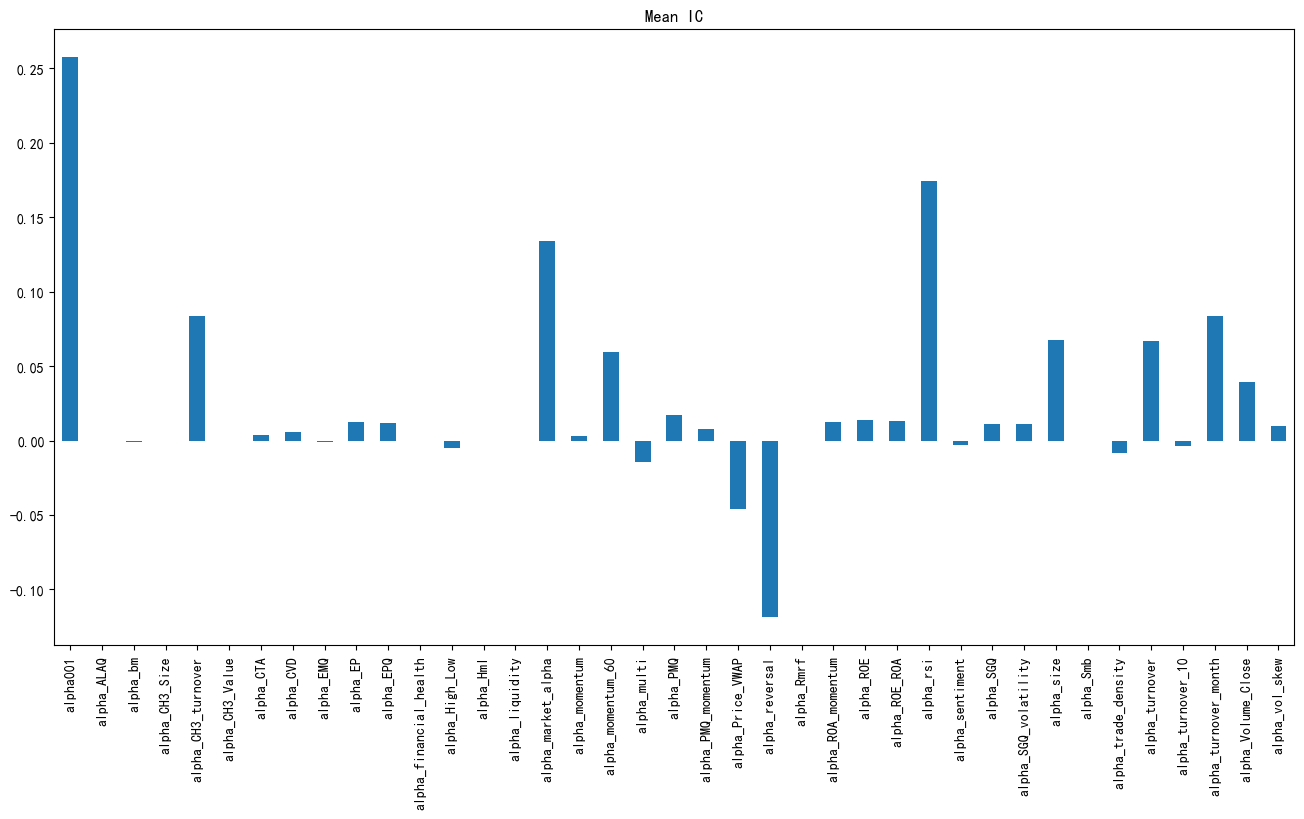

In [35]:
# 可视化 IC 时间序列

plt.figure(figsize=(16, 8))

# ic_results.plot(title="IC Time Series")
mean_ic.plot(kind='bar', title="Mean IC")

100%|██████████| 40/40 [01:21<00:00,  2.04s/it]

            alpha001  alpha_ALAQ  alpha_bm  alpha_CH3_Size  \
date                                                         
2011-05-03       NaN         NaN       NaN             NaN   
2011-05-04       NaN    0.121654  0.139516             NaN   
2011-05-05       NaN    0.076676  0.051097             NaN   
2011-05-06       NaN    0.156870 -0.103619             NaN   
2011-05-09  0.017833    0.133908 -0.079549             NaN   
...              ...         ...       ...             ...   
2016-04-25  0.223263   -0.077103  0.078383             NaN   
2016-04-26  0.265239    0.196304 -0.140845             NaN   
2016-04-27  0.292342    0.048863 -0.022088             NaN   
2016-04-28  0.174513   -0.164770  0.027309             NaN   
2016-04-29  0.218423    0.136566 -0.127105             NaN   

            alpha_CH3_Size_NOT  alpha_CH3_Value  alpha_CH3_Value_NOT  \
date                                                                   
2011-05-03                 NaN              NaN  

<Axes: title={'center': 'IC Time Series'}, xlabel='date'>

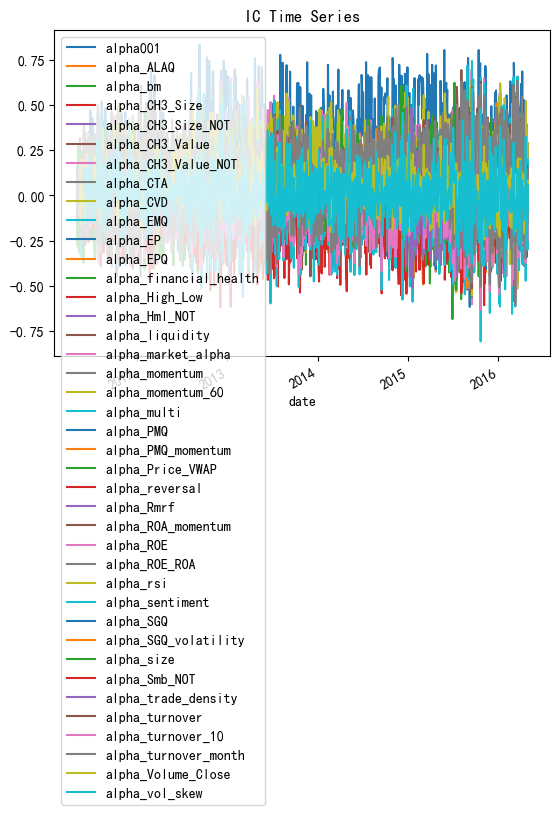

In [49]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# 提取因子名称
factor_names = factors_df.columns.get_level_values(0).unique()

# 创建一个空的 DataFrame 用于存储每个因子的 IC 值
ic_results = pd.DataFrame(index=factors_df.index, columns=factor_names)

# 批量计算
for factor in tqdm(factor_names):
    # 提取所有时间点该因子的值
    factor_values = factors_df[factor]  # 所有股票对应的因子值
    ic_values = []  # 存储 IC 结果

    for date in factors_df.index:
        # 提取该时间点的因子值和收益率
        factor_data = factor_values.loc[date]
        returns_data = returns.loc[date]

        # 对齐数据并去除缺失值
        aligned_data = pd.concat([factor_data, returns_data], axis=1, join="inner").dropna()
        if aligned_data.empty:
            ic_values.append(np.nan)
        else:
            # 计算 Spearman 相关系数
            ic, _ = spearmanr(aligned_data.iloc[:, 0], aligned_data.iloc[:, 1])
            ic_values.append(ic)

    # 将结果存入 DataFrame
    ic_results[factor] = ic_values

# 查看 IC 结果
print(ic_results)

ic_results.to_csv('data/all_ic_results.csv')

# 计算每个因子的平均 IC 值
all_mean_ic = ic_results.mean()

all_mean_ic.to_csv('data/all_mean_ic.csv')

# 可视化 IC 时间序列
ic_results.plot(title="IC Time Series")

<Axes: title={'center': 'Mean IC'}>

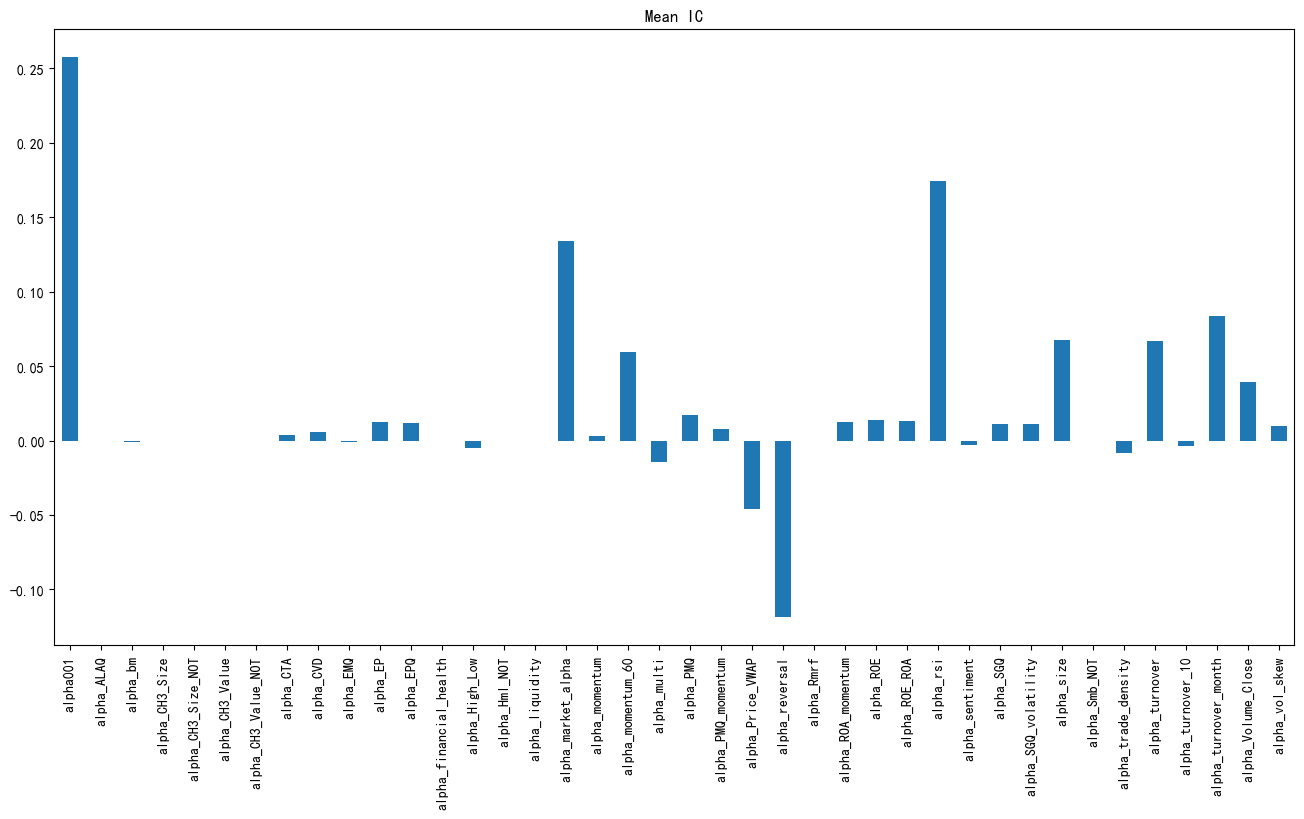

In [50]:
plt.figure(figsize=(16, 8))
all_mean_ic.plot(kind='bar', title="Mean IC")

## 逐步回归

In [20]:
def stepwise_regression(y, X, direction='both', threshold_in=0.05, threshold_out=0.10):
    """
    逐步回归方法，进行特征选择，返回最优模型以及选择的特征
    :param y: 目标变量（依赖变量）
    :param X: 特征变量（自变量）
    :param direction: 选择方法：'forward'、'backward' 或 'both'
    :param threshold_in: 进入模型的显著性水平
    :param threshold_out: 离开模型的显著性水平
    :return: 最优模型以及选择的特征
    """
    initial_vars = X.columns.tolist()
    best_aic = float('inf')
    best_model = None
    remaining_vars = initial_vars.copy()
    selected_vars = []

    while True:
        changed = False
        
        if direction in ['both', 'forward']:  # 前向选择
            # 遍历所有未进入模型的变量
            for var in remaining_vars:
                model = sm.OLS(y, sm.add_constant(X[selected_vars + [var]])).fit()
                aic = model.aic
                # 仅当 AIC 更低时才加入该变量
                if aic < best_aic:
                    best_aic = aic
                    best_model = model
                    best_var = var
                    changed = True
                    selected_vars.append(best_var)
                    remaining_vars.remove(best_var)
                    break  # 只选择一个变量后继续向前

        if direction in ['both', 'backward']:  # 后向剔除
            # 遍历所有已进入模型的变量
            for var in selected_vars:
                temp_selected_vars = selected_vars.copy()
                temp_selected_vars.remove(var)
                model = sm.OLS(y, sm.add_constant(X[temp_selected_vars])).fit()
                aic = model.aic
                # 仅当 AIC 更低时才剔除该变量
                if aic < best_aic:
                    best_aic = aic
                    best_model = model
                    best_var = var
                    changed = True
                    selected_vars.remove(best_var)
                    break  # 只剔除一个变量后继续向后

        if not changed:
            break  # 没有变化，退出循环

    return best_model, selected_vars  # 返回最优模型及选择的特征

In [ ]:
import joblib

# 提取资产列表（多重索引的第二层）
assets = X.columns.get_level_values(1).unique()
# assets = ['601939']
dates = Y.index

# 创建 DataFrame 存储回归结果
regression_betas = pd.DataFrame(columns=['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept'])
expected_columns = ['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept']

regression_models = {}
regression_preds = pd.DataFrame(index=dates, columns=assets)

total_mse_regression = 0

# 对每个资产进行回归
for asset in tqdm(assets):
    # print("asset: ", asset)
    # 提取该资产对应的 Y 和 X
    y = Y[asset].dropna()
    x = X.xs(asset, axis=1, level=1).reindex(y.index)  # 确保时间对齐

    # 添加常数项
    x = sm.add_constant(x)

    # 找出缺失的列
    missing_columns = [col for col in expected_columns if col not in x.columns and col != 'Asset']
    
    # 手动补充缺失列
    for col in missing_columns:
        x[col] = 0

    # 确保列顺序一致
    x = x[expected_columns[1:]]  # 排除 'Asset'，其余列按 expected_columns 的顺序排列
    
    # 对特征进行逐步回归
    stepwise_model, selected_vars = stepwise_regression(y, x)

    # print(selected_vars)
    # print(stepwise_model.summary())
    
    # 获取逐步回归后的预测值
    pred = stepwise_model.predict(sm.add_constant(x[selected_vars]))  # 用最终选择的特征进行预测
    regression_preds[asset] = pred

    # 计算 MSE
    mse_val = mse1(y, pred)
    total_mse_regression += mse_val

    # 记录回归结果
    result = [asset] + list(stepwise_model.params.reindex(expected_columns[1:]).fillna(0).values)
    
    # 保存回归模型
    regression_models[asset] = stepwise_model
    
    # 如果路径不存在，创建路径
    if not os.path.exists('models/regression_models'):
        os.makedirs('models/regression_models')
    
    joblib.dump(stepwise_model, f'models/regression_models/{asset}.pkl')

    # # 回归分析
    # model = sm.OLS(y, x).fit()
    
    # pred = model.predict(x)
    # regression_preds[asset] = pred

    # # 计算 MSE
    # mse_val = mse1(y, pred)
    # total_mse_regression += mse_val

    # # 记录回归结果
    # result = [asset] + list(model.params.reindex(expected_columns[1:]).fillna(0).values)
    
    # # 保存回归模型
    # regression_models[asset] = model

    # 检查 result 的长度和 regression_betas 的列数
    # print("result 的长度:", len(result))
    # print("regression_betas 的列数:", len(regression_betas.columns))

    # regression_betas.loc[len(regression_betas)] = result
    

# 设置列名
# regression_betas.columns = ['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept']

print("MSE:")
print(total_mse_regression)

In [22]:
# 在models文件夹中循环读取模型
import os

# 读取模型
regression_models = {}

# 遍历 'models' 文件夹中的所有文件
models_folder = 'models/regression_models'  # 替换为你的模型文件夹路径
for filename in os.listdir(models_folder):
    if filename.endswith('.pkl'):  # 根据文件扩展名选择模型文件
        model_path = os.path.join(models_folder, filename)
        model_name = os.path.splitext(filename)[0]  # 获取文件名作为模型的名称

        # 读取模型并存入字典
        regression_models[model_name] = joblib.load(model_path)

In [24]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from tqdm import tqdm


# 将 X 从 MultiIndex 转换为面板数据
X_flat = X.stack(level='asset').reset_index()  # 展开资产维度，变为长表
X_flat.columns = ['Date', 'Asset'] + list(X.columns.get_level_values(0).unique())  # 重命名列

# 将 Y 转换为面板数据
Y_flat = Y.stack().reset_index()  # 展开资产维度
Y_flat.columns = ['Date', 'Asset', 'Return']  # 重命名列

# 合并 X 和 Y
panel_data = pd.merge(Y_flat, X_flat, on=['Date', 'Asset'])


def stepwise_regression1(y, X, threshold_in=0.05, threshold_out=0.10):
    """
    实现逐步回归进行特征选择
    :param y: 因变量
    :param X: 自变量数据框
    :param threshold_in: 添加变量的显著性阈值
    :param threshold_out: 删除变量的显著性阈值
    :return: 最优回归模型和选中的变量列表
    """
    included = []  # 已选择变量列表
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:  # 满足进入条件
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True

        # Backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        pvalues = model.pvalues.iloc[1:]  # 排除常数项
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:  # 满足移除条件
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)

        if not changed:  # 如果没有变化，退出循环
            break

    return sm.OLS(y, sm.add_constant(X[included])).fit(), included

# 提取回归的因变量和自变量
y = panel_data['Return']  # 收益率作为因变量
X = panel_data.drop(columns=['Date', 'Asset', 'Return'])  # 剩余列为因子

# 执行逐步回归
stepwise_model, selected_vars = stepwise_regression1(y, X)

# 输出结果
print("Selected Variables:", selected_vars)
print(stepwise_model.summary())

Selected Variables: ['alpha_PMQ_momentum', 'alpha_ROA_momentum', 'alpha_CH3_Value', 'alpha001', 'alpha_ROE', 'alpha_rsi', 'alpha_Rmrf', 'alpha_SGQ', 'alpha_SGQ_volatility', 'alpha_ROE_ROA', 'alpha_reversal', 'alpha_CVD', 'alpha_turnover_10', 'alpha_turnover_month']
                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     589.0
Date:                 周一, 09 12月 2024   Prob (F-statistic):               0.00
Time:                        00:04:02   Log-Likelihood:                 54207.
No. Observations:               77924   AIC:                        -1.084e+05
Df Residuals:                   77909   BIC:                        -1.082e+05
Df Model:                          14                                         
Covariance Type:       

In [23]:
# asset_id = '601939'

assets_id = iter(assets)

In [24]:
# asset_id = next(assets_id)

results = regression_models[asset_id]

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 601939   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     70.88
Date:                Sun, 08 Dec 2024   Prob (F-statistic):          5.55e-140
Time:                        10:42:36   Log-Likelihood:                -1844.2
No. Observations:                1693   AIC:                             3714.
Df Residuals:                    1680   BIC:                             3785.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
alpha_CVD               -0.4605 

In [25]:
# 找到R2最大的模型
max_R2 = 0
max_R2_asset = None
for asset_id in assets:
    results = regression_models[asset_id]
    
    # 截距项要大于0
    if results.rsquared > max_R2 and results.params['const'] > 0:
        max_R2 = results.rsquared
        max_R2_asset = asset_id
        
print(max_R2)
print(max_R2_asset)

max_R2_model = regression_models[max_R2_asset]
print(max_R2_model.summary())

0.41943444416549713
601989
                            OLS Regression Results                            
Dep. Variable:                 601989   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     54.98
Date:                Sun, 08 Dec 2024   Prob (F-statistic):          2.06e-155
Time:                        10:42:36   Log-Likelihood:                -1348.8
No. Observations:                1466   AIC:                             2738.
Df Residuals:                    1446   BIC:                             2843.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const

## GRS检验

In [26]:
from scipy.stats import f

def grs_test(models_dict, X, y):
    """
    GRS 检验
    :param models_dict: 模型字典，键为资产名称，值为模型
    :param X: 自变量，DataFrame 格式，索引为日期，列为因子
    :param y: 因变量，DataFrame 格式，索引为日期，列为资产
    :return: GRS 检验的统计量
    """
    # 提取资产列表
    assets = list(models_dict.keys())
    # 提取时间序列
    dates = y.index

    # 提取模型数量
    num_models = len(models_dict)

    # 提取自变量数量
    num_vars = X.columns.get_level_values(0).unique().size

    # 提取残差
    residuals = pd.DataFrame(index=dates, columns=assets)
    y_pred = pd.DataFrame(index=dates, columns=assets)
    for asset, model in models_dict.items():
        
        selected_var = model.params.index.tolist()
        
        x = X.xs(asset, axis=1, level=1).reindex(dates)
        x = sm.add_constant(x)
        x['Intercept'] = 1
        x = x[selected_var]
        
        residuals[asset] = y[asset] - model.predict(x)
        
        y_pred[asset] = model.predict(x)

    # 计算残差的协方差矩阵
    residuals_cov = residuals.cov()
    
    if np.linalg.det(residuals_cov) == 0:
        # 如果协方差矩阵是奇异的，尝试加一些正则化
        residuals_cov += np.eye(residuals_cov.shape[0]) * 1e-6 

    # 计算因变量的均值
    y_mean = y.mean()

    # 计算因变量的协方差矩阵
    y_cov = y.cov()

    # 计算协方差矩阵的逆
    y_cov_inv = np.linalg.inv(y_cov)

    # 计算 GRS 统计量
    grs_statistic = dates.size / num_vars * (y_pred - y_mean).T @ y_cov_inv @ (y_pred - y_mean) / (1 + y_pred @ np.linalg.inv(residuals_cov) @ y_pred.T)
    
    print(dates.size)
    print(num_vars)
    
    # 自由度
    dfn = num_models - 1
    dfd = dates.size - num_vars
    
    print(f"GRS 统计量: {grs_statistic}, dfn: {dfn}, dfd: {dfd}")
    
    # 计算 p 值
    p_value = 1 - f.cdf(grs_statistic, dfn, dfd)

    print(f"GRS 统计量: {grs_statistic}, p 值: {p_value}")
    

    if np.isnan(grs_statistic):
        return 0
    return grs_statistic

## XGBoost

滚动回归

In [18]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from tqdm import tqdm
import joblib

# 假设 X 和 Y 已经定义，且每列对应不同的资产，dates 是时间索引
# 获取资产列表
asset_list = X.columns.get_level_values(1).unique()
asset_list = ['601939']

# 存储每个资产的 XGBoost 模型和预测结果
xgb_models = {}
xgb_preds = pd.DataFrame(index=dates, columns=asset_list)

# 滚动窗口设置
window_size = 252  # 滑动窗口的大小，例如最近60个时间点
test_size = 30  # 每次滚动预测未来20个时间点
total_mse_xgb = 0

# 截取时间段
Y1 = Y[(Y.index >= '2016-04-30') & (Y.index <= '2019-4-30')]
X1 = X[(X.index >= '2016-04-30') & (X.index <= '2019-4-30')]

# 对每个资产进行滚动回归
for asset_id in tqdm(asset_list):
    # 提取资产对应的 Y 和 X
    target_y = Y1[asset_id].dropna()
    feature_x = X1.xs(asset_id, axis=1, level=1).reindex(target_y.index)
    
    # 滚动窗口
    for start in range(len(feature_x) - window_size - test_size + 1):
        # 定义训练集和测试集索引
        train_end = start + window_size
        test_end = train_end + test_size
        
        X_train = feature_x.iloc[start:train_end]
        y_train = target_y.iloc[start:train_end]
        X_test = feature_x.iloc[train_end:test_end]
        y_test = target_y.iloc[train_end:test_end]
        
        # 使用 XGBoost 进行回归
        model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=4,
            random_state=42,
            early_stopping_rounds=10
        )
        
        # 使用验证集进行早停
        val_size = int(0.2 * len(X_train))
        X_train_split, X_val = X_train[:-val_size], X_train[-val_size:]
        y_train_split, y_val = y_train[:-val_size], y_train[-val_size:]
        
        model.fit(
            X_train_split, y_train_split,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
        # 保存模型（如果需要）
        start_date = X_train.index[0].strftime('%Y%m%d')
        
        # 如果路径不存在，创建路径
        if not os.path.exists('models/xgb_models_rolling'):
            os.makedirs('models/xgb_models_rolling')
        
        model_filename = f'models/xgb_models_rolling/{asset_id}_window_{start_date}.pkl'
        joblib.dump(model, model_filename)
        
        # 预测
        predictions = model.predict(X_test)
        xgb_preds.loc[X_test.index, asset_id] = predictions
        
        # 计算误差
        mse = mean_squared_error(y_test, predictions)
        total_mse_xgb += mse

# 输出平均 MSE
average_mse_xgb = total_mse_xgb / (len(asset_list) * (len(feature_x) - window_size - test_size + 1))
print(f"Average MSE across all assets: {average_mse_xgb}")

100%|██████████| 1/1 [00:17<00:00, 17.88s/it]

Average MSE across all assets: 0.06347096671579501


In [19]:
# 读取模型
asset_id = '601939'
reg_date = '20160530'

xgb_rolling_model = joblib.load(f'models/xgb_models_rolling/{asset_id}_window_{reg_date}.pkl')

# 提取资产对应的 Y 和 X
target_y = Y1[asset_id].dropna()
feature_x = X1.xs(asset_id, axis=1, level=1).reindex(target_y.index)

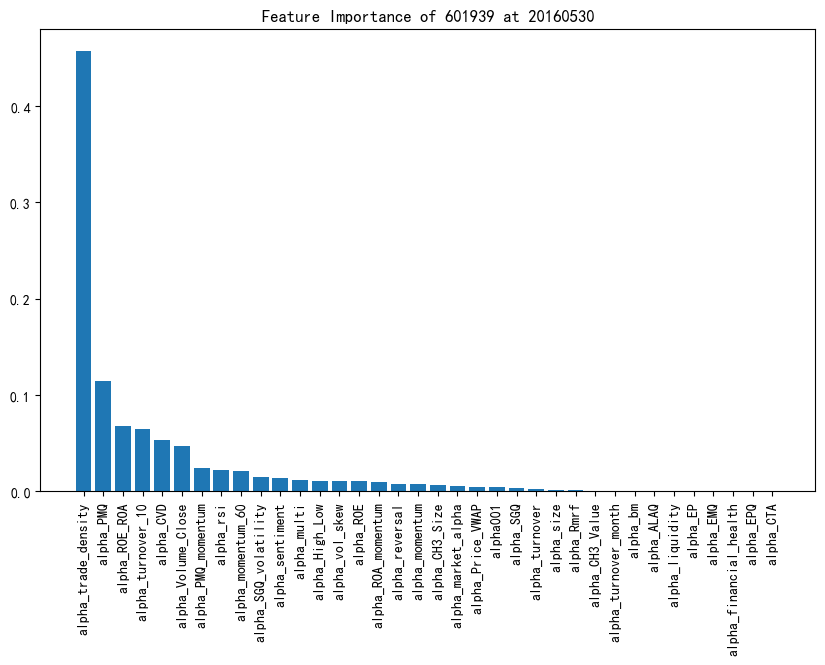

In [20]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
import matplotlib

# 让图像可以在notebook中展示
%matplotlib inline

features = xgb_rolling_model.get_booster().feature_names

summary = pd.DataFrame(xgb_rolling_model.feature_importances_, index=features, columns=['Importance']) #X.columns.get_level_values(0).unique()
summary = summary.sort_values(by='Importance', ascending=False)

# 画图
plt.figure(figsize=(10, 6))
plt.bar(summary.index, summary['Importance'])
plt.xticks(rotation=90)
plt.title(f'Feature Importance of {asset_id} at {reg_date}')
plt.show()

非滚动回归

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split, KFold, cross_val_score
# from sklearn.metrics import mean_squared_error
# from xgboost import XGBRegressor
# import numpy as np



# # 获取资产列表
# asset_list = X.columns.get_level_values(1).unique()

# # 存储每个资产的 XGBoost 模型和预测结果
# xgb_models = {}
# xgb_preds = pd.DataFrame(index=dates, columns=asset_list)

# total_mse_xgb = 0

# # 对每个资产进行回归
# for asset_id in tqdm(asset_list):
#     # 提取资产对应的 Y 和 X
#     target_y = Y[asset_id].dropna()
#     feature_x = X.xs(asset_id, axis=1, level=1).reindex(target_y.index)
    
#     # 划分训练集和测试集，使用最后 20% 的数据作为测试集
#     train_size = int(0.8 * len(feature_x))
#     X_train, X_test = feature_x[:train_size], feature_x[train_size:]
#     y_train, y_test = target_y[:train_size], target_y[train_size:]

#     # 使用交叉验证选择最佳模型
#     param_grid = {
#         'n_estimators': [10, 20, 30],  # 决策树数量
#         'learning_rate': [0.01, 0.05, 0.1],  # 学习率
#         'max_depth': [3, 4, 5],  # 最大树深度
#         'reg_alpha': [0, 0.1, 1],  # L1 正则化
#         'reg_lambda': [0, 0.1, 1],  # L2 正则化
#     }
    
#     best_model = None
#     best_score = float('inf')  # 用于记录最优模型的评分
    
#     # 交叉验证（5折交叉验证）
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
#     for n_estimators in param_grid['n_estimators']:
#         for learning_rate in param_grid['learning_rate']:
#             for max_depth in param_grid['max_depth']:
#                 xgb_regressor = XGBRegressor(
#                     n_estimators=n_estimators,
#                     learning_rate=learning_rate,
#                     max_depth=max_depth,
#                     random_state=42
#                 )
                
#                 # 交叉验证评分
#                 scores = cross_val_score(xgb_regressor, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
#                 mean_score = -scores.mean()  # 负 MSE 转为正值
                
#                 # 选择最优模型
#                 if mean_score < best_score:
#                     best_score = mean_score
#                     best_model = xgb_regressor
                
#     # 使用最优超参数训练模型
#     best_model.fit(X_train, y_train)

#     # 保存最佳模型
#     # xgb_models[asset_id] = best_model
#     joblib.dump(best_model, f'models/xgb_models/{asset_id}.pkl')

#     # 预测
#     xgb_pred = pd.DataFrame(best_model.predict(X_test), index=X_test.index, columns=[asset_id])

#     # 保存预测结果
#     # xgb_preds[asset_id] = xgb_pred

#     # 计算测试集上的 MSE
#     mse1 = mean_squared_error(y_test, xgb_pred)
#     total_mse_xgb += mse1
#     # print(f"Asset {asset_id} MSE: {mse}")

# # 输出所有资产的总 MSE
# average_mse_xgb = total_mse_xgb / len(asset_list)
# print(f"Average MSE across all assets: {average_mse_xgb}")

  0%|          | 0/288 [00:00<?, ?it/s]

  6%|▋         | 18/288 [01:32<23:14,  5.16s/it]


KeyboardInterrupt: 

In [ ]:
# 在models文件夹中循环读取模型
import os

# 读取模型
xgb_models = {}

# 遍历 'models' 文件夹中的所有文件
models_folder = 'models/xgb_models'  # 替换为你的模型文件夹路径
for filename in os.listdir(models_folder):
    if filename.endswith('.pkl'):  # 根据文件扩展名选择模型文件
        model_path = os.path.join(models_folder, filename)
        model_name = os.path.splitext(filename)[0]  # 获取文件名作为模型的名称

        # 读取模型并存入字典
        xgb_models[model_name] = joblib.load(model_path)

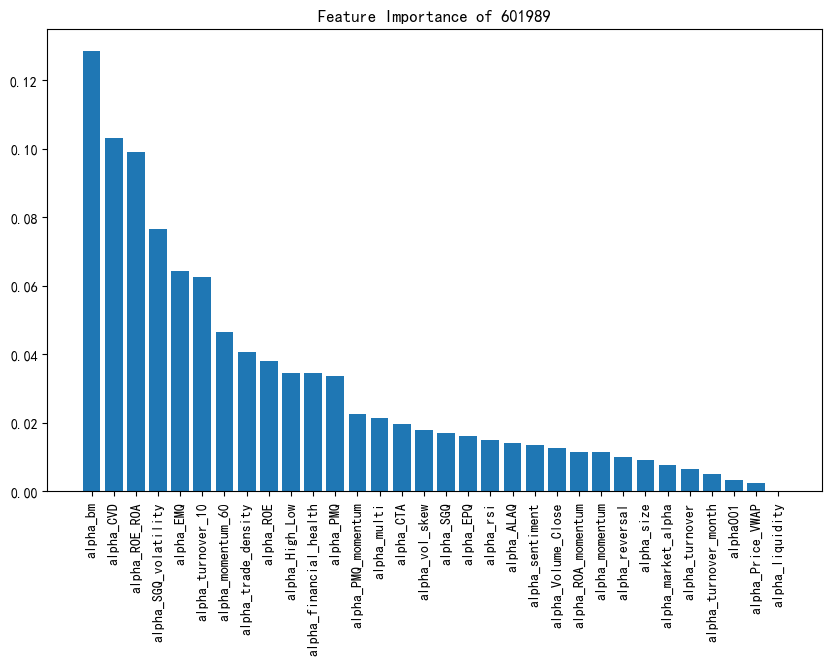

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
import matplotlib

# 让图像可以在notebook中展示
%matplotlib inline

# 选择一个特定的资产，比如 '601939'
asset_id = '601989'

# 提取该资产对应的 XGBoost 模型
xgb_model = xgb_models[asset_id]

features = xgb_model.get_booster().feature_names

summary = pd.DataFrame(xgb_model.feature_importances_, index=features, columns=['Importance']) #X.columns.get_level_values(0).unique()
summary = summary.sort_values(by='Importance', ascending=False)

# 画图
plt.figure(figsize=(10, 6))
plt.bar(summary.index, summary['Importance'])
plt.xticks(rotation=90)
plt.title(f'Feature Importance of {asset_id}')
plt.show()


In [ ]:
# 画散点图
plt.rcParams['axes.unicode_minus'] = False
def plot_y_and_pred(y, pred, asset_id, ifshow=True):
    plt.figure(figsize=(10, 6))
    plt.scatter(y.index, y, label='True', s = 5)
    plt.scatter(pred.index, pred, label='Predicted', s = 5)
    plt.title(f'True and Predicted Returns of {asset_id}')
    plt.legend()
    
    if ifshow:
        plt.show()
        
    else:
        plt.savefig(f'output_charts/predicts/{asset_id}.png')
        plt.close()

In [ ]:
assets

Index(['000001', '000002', '000009', '000012', '000021', '000027', '000031',
       '000039', '000046', '000059',
       ...
       '601898', '601899', '601918', '601919', '601939', '601958', '601988',
       '601989', '601991', '601998'],
      dtype='object', name='asset', length=288)

(2918, 9216) (2918,) (2918,)
Test MSE: 0.3900718678308195


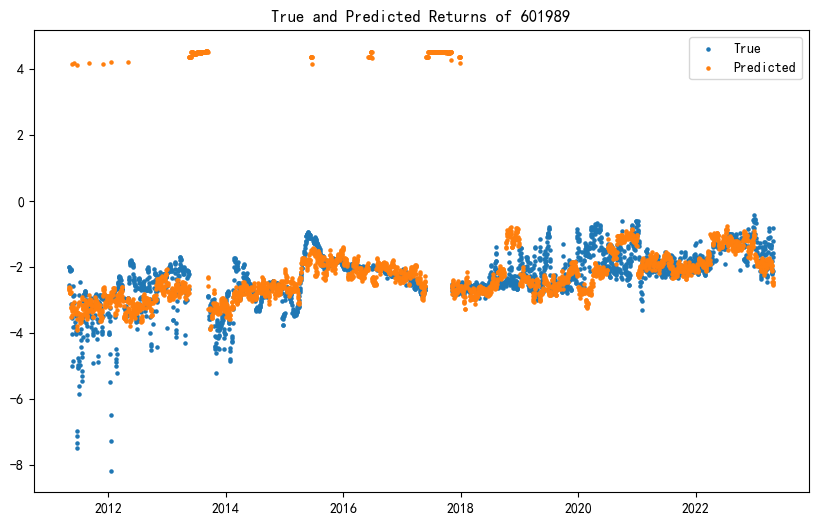

(2918, 9216) (2918,) (2918,)
Test MSE: 0.5193416141494174


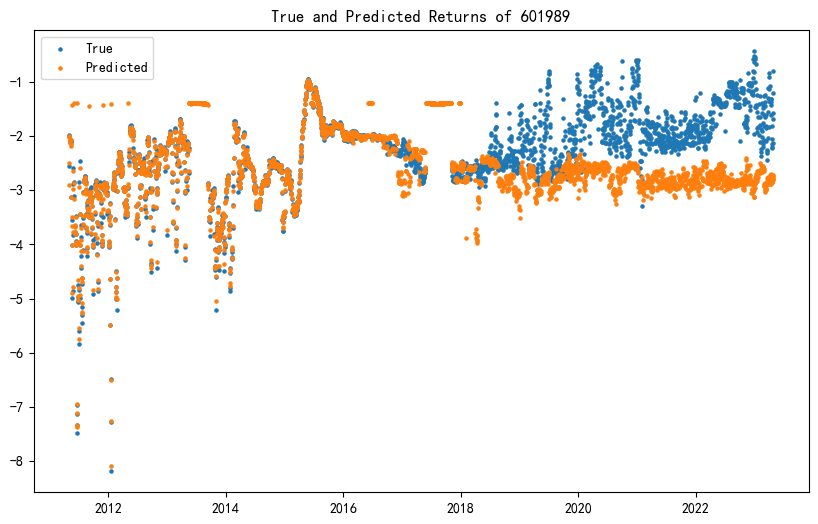

In [ ]:
# 提取该资产对应的 Y 和 pred
y1 = returns - df_all_pivot['rf'].values
index_all = y1.index
X1 = df_all_pivot.drop(['rf', 'alpha_Fama_French', 'open', 'close', 'high', 'low', 'volume', 'amount', 'pctChg', 'cta', 'roe','vwap', 'pctChg',
       'turnover', 'benchmark_open', 'benchmark_close', 'benchmark_high',
       'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd', 'epq', 'emq',
       'sgq', 'alaq', 'pmq', 'cta', 'size', 'rf', 'bm', 'ep', 'alpha_Rmrf', 'alpha_CH3', 'alpha_EP'], axis=1, level=0)

def plot_test_pred(y, X, asset_id, ifshow=True, isXgb=True):
       y1 = y[asset_id].dropna()
       y1 = pd.Series(y1, index=index_all)

       if isXgb:
              pred = xgb_models[asset_id].predict(X.xs(asset_id, axis=1, level=1))
       else:
              model = regression_models[asset_id]
              selected_vars = model.params.index.tolist()
              
              isIntercept = False
              if('Intercept' in selected_vars):
                     isIntercept = True
              isconst = False
              if('const' in selected_vars):
                     isconst = True
              
              selected_vars = [var for var in selected_vars if var != 'const' and var != 'Intercept']
              
              # print(model.params)
              
              # print(model.params.shape)
              X2 = X.xs(asset_id, axis=1, level=1)[selected_vars]
              
              if 'const' not in X2.columns and isconst:
                     X2 = sm.add_constant(X2)
              if isIntercept:
                     X2['Intercept'] = 1
                     
              # print(X2.columns)
              
              pred = model.predict(X2)
       pred = pd.Series(pred, index=index_all)
       
       print(X.shape, y1.shape, pred.shape)
       
       test_mse = mse1(y1, pred)
       print(f"Test MSE: {test_mse}")       
       
       plot_y_and_pred(y1, pred, asset_id, ifshow)
       
asset_id = '601989'

plot_test_pred(y1, X1, asset_id, isXgb=False)
plot_test_pred(y1, X1, asset_id, isXgb=True)

In [ ]:
# 保存预测结果为因子形式

import os
from utils import rank

def save_to_factors(X, isXgb=True):
    results_pred = pd.DataFrame(index=all_time_index, columns=assets)
    for asset_id in tqdm(assets):
        if isXgb:
            pred = xgb_models[asset_id].predict(X.xs(asset_id, axis=1, level=1))
        else:
            model = regression_models[asset_id]
            selected_vars = model.params.index.tolist()
            
            isIntercept = False
            if('Intercept' in selected_vars):
                    isIntercept = True
            isconst = False
            if('const' in selected_vars):
                    isconst = True
            
            selected_vars = [var for var in selected_vars if var != 'const' and var != 'Intercept']
            
            # print(model.params)
            
            # print(model.params.shape)
            X2 = X.xs(asset_id, axis=1, level=1)[selected_vars]
            
            if 'const' not in X2.columns and isconst:
                    X2 = sm.add_constant(X2)
            if isIntercept:
                    X2['Intercept'] = 1
                    
            # print(X2.columns)
            
            pred = model.predict(X2)
            
        pred = pd.Series(pred, index=all_time_index)
        
        results_pred[asset_id] = pred
    
    results_pred = rank(results_pred)
        
    # 如果路径不存在，创建路径
    if not os.path.exists('alphas/multialpha'):
        os.makedirs('alphas/multialpha')
    
    results_pred.to_csv(f'alphas/multialpha/20110430/alpha_isXgb_{isXgb}.csv')


In [ ]:
save_to_factors(X1)

In [ ]:
save_to_factors(X1, isXgb=False)

  0%|          | 0/288 [00:00<?, ?it/s]

100%|██████████| 288/288 [00:00<00:00, 339.10it/s]
